<br><br><img src="https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Images/CapstoneA2Logo.InstituteDataAnalytics.png?raw=true" alt="Drawing" style="width: 400px;float: left;"/>
<img src="https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Images/lablocsci_logo_bg.png?raw=true" alt="Drawing" style="width: 400px;float: right;"/><br><br><br><br><br><br>
<br><br><br><br><br><br>
This Jupyter Notebook highlights the "Step-by-Step" analytic procedures of assessing physical access to registered Substance Abuse and Mental Health Services Administration (SAMHSA) opioid medical assisted treatment (MAT) locations in the US. Physical access is defined as travel time between MAT locations and US Census Tract centroids.<br><br>Due to the size of the data, some analyses and data management activities were performed on a SQL server with 60 cores and 2TB or RAM. Elements of the analyses done outside of Python will reference SQL code located in another link on our GITHUB repository. <br><br>Findings from this study is presented in _"Geographic Disparities in Accessibility to Long-Term Methadone and Buprenorphine Treatment among Adults in the United States"_ by Mitchell et. al (currently under peer review) doi: TBD. Input data used in analyses is available for download at: https://github.com/lewis060-UAT/xcjvb_2363/tree/master/Input%20Files. Also, the origin destination matrix used in analyses is not available for download in our repository due to license agreement restrictions associated with ESRI's StreetMap Premium.<br><br>For several years, scholars have endorsed the expanded availability of MAT for Opioid Use Disorder (OUD) to reduce the challenges that the opioid epidemic is having on the nation's population health. To date, few studies have operationalized physical access to MAT using methods considered robust in GIS research. As such, this study focuses on two questions: 
1. What does physical access to MAT look like in the United States?
2. Does physical access to MAT vary by rurality and socioeconomic deprivation?<br>

<font color=blue> Note:  The authors used the Python3 environment created by ESRI, and is available with the purchase of ArcGIS Pro. Some Python3 libraries used in analyses may not be  compatitble with versions of libraries installed on other PCs. Also, the authors also pip installed the following libraries to the ArCGIS Python environment: pyodbc,statsmodels, pingouin, and sqlalchemy. Please read output log to determine if pip installtion of additional libraries are needed.</font>

##  The data used in analysis:
### 1. The Structure:
<img src="https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Images/Opioid%20Paper%20E-R%20Diagram%20-%20ER%20Diagram2.png?raw=true" alt="Drawing" style="width: 2000px;float: left;"/><br><br><br><br><br><br>
### 2. The Details:
<img src="https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Images/Opioid%20Paper%20E-R%20Diagram%20-%20Data%20Sources.png?raw=true" alt="Drawing" style="width: 2000px;float: left;"/>

The code below import `Python3` libraries used to execute analyses with some additional options to enhance processing and result output

In [1]:
#arcpy is used to execute arcgis geoprocessing tools
import arcpy
import os
#Pandas and Numpyis used to perform simple analytics and datamanagement tasks
import pandas as pd
import numpy as np
#Matplotlib will be used to show figures
import matplotlib.pyplot as plt
%matplotlib inline
# importing to estimate beta weights for decay
import scipy
from scipy.optimize import curve_fit
# import to connect to SQL server where our data is stored
import pyodbc
from sqlalchemy import create_engine
import urllib
# Used to encrypt url, username, and passwords for our SQL Server
# So that we can share "actual" code used in analyses
import getpass

# The time library is being imported so that readers will know how long the process to run some models take
import time

# import to compare distribution of accessibility between rural status
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import pairwise_tukey


# Use more cores on this machine.The server in our analysis has 60-cores and 2TB of ram
arcpy.env.parallelProcessingFactor = "50%"
#The two lines below allows us to see all rows and columns
#By default, pandas does not show all coluns and rows of large dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = None 
# option to eliminate warnings associated with chained code to reference columns
pd.options.mode.chained_assignment = None 

Code below is to connect to our `SQL server` where data described in above `E-R Diagram` is stored.

In [2]:
print('Enter your server address (entry is encrypted):')
server_name = str(getpass.getpass())
print('Enter database name where data is stored (entry is encrypted):')
db_name = str(getpass.getpass())
print('Enter your username to connect to server (entry is encrypted):')
user = str(getpass.getpass())
print('Enter your server password to connect to server (entry is encrypted):')
password = getpass.getpass()

# We use this code block to establish connection to retrieve data from server
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server="+server_name+";"
                        "Database="+db_name+";"
                        "uid="+user+";pwd="+password)

Enter your server address (entry is encrypted):
········
Enter database name where data is stored (entry is encrypted):
········
Enter your username to connect to server (entry is encrypted):
········
Enter your server password to connect to server (entry is encrypted):
········


The code below displays the downward log logistic travel time decay as estimated using data generated from Figure 1 from Rosenblum and colleagues research (2011):
>Rosenblum A, Cleland CM, Fong C, Kayman DJ, Tempalski B, Parrino M. Distance traveled and cross-state commuting to opioid treatment programs in the United States. Journal of environmental and public health. 2011 Jan 1;2011.doi: https://doi.org/10.1155/2011/948789

Data used in this analysis can be found here: https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Input%20Files/OTP_Article_TravelDistribution.txt

The downward log-logistic formula is:
$$\huge W_{ij}   = \frac{\gamma}{1 + (\frac{d}{\beta_{0}})^{\beta_{1}}}$$
<br>
$$\large \text{, where  } \gamma \text{= 1 and d=Travel Time}$$

<br><br><font color=blue> Note:  Because we used a Google application to generate data from an image, there are some errors in the analyses. The most significant being that some rows have miles traveled as "0" instead of a number like "1." As such, we get a "divide by zero error" in line 3 of code</font>

b0 for OTP Article decay is:  7.272908419897528
b1 for OTP Article decay is:  1.4115654379520726
RMSE: 0.008257998454671168
R-squared: 0.9983688898007341


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


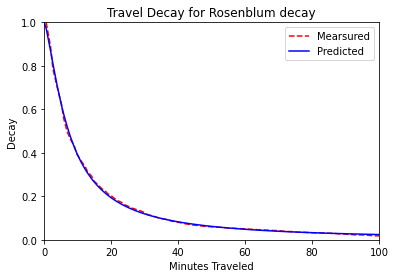

In [3]:
df = pd.read_sql_query("select * from dbo.OTP_Article_TravelDistribution" , cnxn)
newDF=df[['id','Miles_traveled2']]
newDF.loc[:,'travMiInv']=(1/newDF['Miles_traveled2']).copy()
rank=newDF.groupby('Miles_traveled2').count()
rank.loc[:,'count'] = rank['id']
rank=rank[['count']]
rank=rank.reindex(index=rank.index[::-1])
rank.loc[:,'Miles_traveled2'] = rank.index
rank.loc[:,'cum_sum'] = rank['count'].cumsum()
rank.loc[:,'cum_perc'] = rank['cum_sum']/rank['count'].sum()
d = rank['Miles_traveled2'].values
y = rank['cum_perc'].values

# the non-linear model
def model(d,b0,b1):
    return 1/(1+((d/b0)**b1))

#initial guess
p0 = [30,20] 

# curve fit the test data
fittedParameters, pcov = curve_fit(model,d,y, p0, maxfev=1000000)

OTP_Art = fittedParameters
print('b0 for OTP Article decay is: ',str(fittedParameters[0]))
print('b1 for OTP Article decay is: ',str(fittedParameters[1]))

modelPredictions = model(d, *fittedParameters) 

absError = modelPredictions - y

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(y))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


#predictions
y_hat = model(d,fittedParameters[0],fittedParameters[1])
y_bar = np.sum(y)/len(y) 
ssreg = numpy.sum((y_hat-y_bar)**2)
sstot = numpy.sum((y - y_bar)**2)

plt.figure()
plt.title('Travel Decay for Rosenblum decay')
plt.plot(d,y,'r--',label='Mearsured')
plt.plot(d,y_hat,'b-',label='Predicted')
plt.ylabel('Decay')
plt.xlabel('Minutes Traveled')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend(loc='best')
plt.show()

The code below displays the downward log logistic travel time decay as estimated using an approach by Delamater and colleagues research (2019) :
>Delamater PL, Shortridge AM, Kilcoyne RC. Using floating catchment area (FCA) metrics to predict health care utilization patterns. BMC health services research. 2019 Dec 1;19(1):144. doi: https://doi.org/10.1186/s12913-019-3969-5

The floating catchment model integrating beta weights from the minimum travel time decay of this article was statistically correlated with Hospital utilization in Delamater's study.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


b0 for minimum DLL decay is:  5.604657553822013
b1 for minimum DLL decay is:  1.9789660191972298
RMSE: 0.01349317769752297
R-squared: 0.9980360333951644


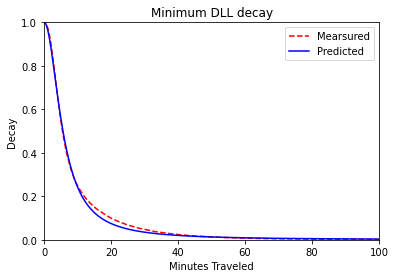

In [4]:
df = pd.read_sql_query("""SELECT GEOID_Data as id, 
                          min(Total_TravelTime) as Total_TravelTime 
                          FROM [final_data_4OpioidPaper].[dbo].[OD]
                          Group by GEOID_Data""" , cnxn)
newDF=df[['id','Total_TravelTime']]
newDF.loc[:,'travMiInv']=(1/newDF['Total_TravelTime']).copy()
rank=newDF.groupby('Total_TravelTime').count()
rank.loc[:,'count'] = rank['id']
rank=rank[['count']]
rank=rank.reindex(index=rank.index[::-1])
rank.loc[:,'Total_TravelTime'] = rank.index
rank.loc[:,'cum_sum'] = rank['count'].cumsum()
rank.loc[:,'cum_perc'] = rank['cum_sum']/rank['count'].sum()
d = rank['Total_TravelTime'].values
y = rank['cum_perc'].values

# the non-linear model
def model(d,b0,b1):
    return 1/(1+((d/b0)**b1))

#initial guess
p0 = [30,20] 

# curve fit the test data
fittedParameters, pcov = curve_fit(model,d,y, p0, maxfev=1000000)

Min_DLL = fittedParameters
print('b0 for minimum DLL decay is: ',str(fittedParameters[0]))
print('b1 for minimum DLL decay is: ',str(fittedParameters[1]))

modelPredictions = model(d, *fittedParameters) 

absError = modelPredictions - y

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(y))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

#predictions
y_hat = model(d,fittedParameters[0],fittedParameters[1])
y_bar = np.sum(y)/len(y) 
ssreg = numpy.sum((y_hat-y_bar)**2)
sstot = numpy.sum((y - y_bar)**2)

plt.figure()
plt.title('Minimum DLL decay')
plt.plot(d,y,'r--',label='Mearsured')
plt.plot(d,y_hat,'b-',label='Predicted')
plt.ylabel('Decay')
plt.xlabel('Minutes Traveled')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend(loc='best')
plt.show()

Now that we have estimated our decay functions, now we will measure physical access to MAT using the Enhanced Two-Step Floating Catchment Area (E2SFCA) and Modified Two-Step Floating Catchment Area (M2SFCA) methods as developed by Lou and Qi (2009) and Delamater (2013), respectively:
>1. Luo W, Qi Y. An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place. 2009 Dec 1;15(4):1100-7. doi: https://doi.org/10.1016/j.healthplace.2009.06.002
>2. Delamater PL. Spatial accessibility in suboptimally configured health care systems: A modified two-step floating catchment area (M2SFCA) metric. Health & place. 2013 Nov 1;24:30-43. doi: https://doi.org/10.1016/j.healthplace.2013.07.012

The first step in the E2SFCA is to calculate the supply to demand ratio for each MAT-related location $j$ ($R_{j}$) by dividing the supply ($S_{j}$) by the potential demand of adults within each census tract between the ages of 18 and 64 years as estimated by the American Community Survey($D_{k}$) within 60 minutes travel time $(d_{0})$. The population count for each facility is discounted by a percentage (0-100%) as estimated in our decay function $W_{ij}$, given travel time $(d_{kj})$:

<br>
$$\huge
R_j   = \frac{S_j}{\sum_{i\in[d_{kj} \leq  d_0]} D_kW_{ij}}
$$


The second step in the E2SFCA is to estimate the decay-weighted sum of the supply to demand ratios ($R_{j}$) falling within the threshold travel time of each population/census tract unit i. $A_{i}$ is the accessibility score representing physical access for the census tract:


<br>
$$\huge
A_i   = \sum\limits_{j\in[d_{ij} \leq  d_0]}R_jW_{ij}
$$


As stated by Delamater and colleagues (2019), in their study examining the correlation of floating catchment metrics with hospital utilization, the M2SFCA builds on the E2SFCA, where the steps described for the E2SFCA is adjusted by estimating the supply to demand ratios for each MAT-related facility and population unit combination $(D_{ij})$:


<br>
$$\huge
D_{ij}   = \frac{S_jW_{ij}}{\sum_{i\in[d_{kj} \leq  d_0]} D_kW_{ij}}
$$


The second step of the M2SFCA is to aggregate the adjusted supply to demand ratios ($D_{ij}$) falling within the threshold travel time of each population/census tract unit i:


<br>
$$\huge
A_i   = \sum\limits_{j\in[d_{ij} \leq  d_0]}D_{ij}W_{ij}
$$


Physical access to measured for buprenorphine licensed providers and OTP facilities separately. Also, acess to MAT-related facilities are standardized to represent the number of locations per 10,000 adults aged 18-64 years. Lastly, due to the computational overhead associated with these methodologies, the analytic steps to estimate accessibility were created using a function stored in the authors' SQL server. The code to create the functions are located here: https://github.com/lewis060-UAT/xcjvb_2363/blob/master/Code%20With%20Results%20in%20Output/Floating_Catchment_MSSQL_Server_Functions.sql. The instructions on how to use the SQL functions are located as comments at the end of the previsouly mentioned _.sql_ file. Python was used to call the function in our SQL Server.

In [5]:
# E2SFCA Buprenorphine - Rosenblum Decay
# Note: GEOID_Data is US Census Tract
# b0 for OTP Article decay is:  7.272908419897528
# b1 for OTP Article decay is:  1.4115654379520726

start_time = time.time()

bup_OTPDecay = pd.read_sql_query("""SELECT *,
                                'Buprenorphine' as FacilityType
                                 FROM enhanced_2SFCA(60,
                                                     7.272908419897528,
                                                     1.4115654379520726,
                                                     'Buprenorphine', '','OTP Article')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
bup_OTPDecay.head()

This block of code took this many seconds to complete:  51.68358039855957


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US08013012401,2.686308,E2SFCA,60,OTP Article,Buprenorphine
1,14000US12031012200,3.122461,E2SFCA,60,OTP Article,Buprenorphine
2,14000US24005490605,6.584895,E2SFCA,60,OTP Article,Buprenorphine
3,14000US34015501102,5.052619,E2SFCA,60,OTP Article,Buprenorphine
4,14000US47037017000,5.531166,E2SFCA,60,OTP Article,Buprenorphine


In [6]:
# E2SFCA OTP - Rosenblum Decay
# Note: GEOID_Data is US Census Tract
# b0 for OTP Article decay is:  7.272908419897528
# b1 for OTP Article decay is:  1.4115654379520726

start_time = time.time()

otp_OTPDecay = pd.read_sql_query("""SELECT *,
                                'OTP' as FacilityType
                                 FROM enhanced_2SFCA(60,
                                                     7.272908419897528,
                                                     1.4115654379520726,
                                                     'OTP', '','OTP Article')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
otp_OTPDecay.head()

This block of code took this many seconds to complete:  31.759010553359985


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US06111006302,0.054791,E2SFCA,60,OTP Article,OTP
1,14000US16005981800,0.000000,E2SFCA,60,OTP Article,OTP
2,14000US22079012200,0.190065,E2SFCA,60,OTP Article,OTP
3,14000US27115950800,0.000000,E2SFCA,60,OTP Article,OTP
4,14000US39061005500,0.265590,E2SFCA,60,OTP Article,OTP


In [7]:
# E2SFCA Buprenorphine - Minimum DLL Decay
# Note: GEOID_Data is US Census Tract
# b0 for minimum DLL decay is:  5.604657553822013
# b1 for minimum DLL decay is:  1.9789660191972298

start_time = time.time()

bup_Min_DLLDecay = pd.read_sql_query("""SELECT *,
                                'Buprenorphine' as FacilityType
                                 FROM enhanced_2SFCA(60,
                                                     5.604657553822013,
                                                     1.9789660191972298,
                                                     'Buprenorphine', '','DLL Minimum')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
bup_Min_DLLDecay.head()

This block of code took this many seconds to complete:  52.317983865737915


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US06111006302,1.414346,E2SFCA,60,DLL Minimum,Buprenorphine
1,14000US16005981800,2.038509,E2SFCA,60,DLL Minimum,Buprenorphine
2,14000US22079012200,6.641322,E2SFCA,60,DLL Minimum,Buprenorphine
3,14000US27115950800,1.065267,E2SFCA,60,DLL Minimum,Buprenorphine
4,14000US39061005500,6.806003,E2SFCA,60,DLL Minimum,Buprenorphine


In [8]:
# E2SFCA OTP - Minimum DLL Decay
# Note: GEOID_Data is US Census Tract
# b0 for minimum DLL decay is:  5.604657553822013
# b1 for minimum DLL decay is:  1.9789660191972298

start_time = time.time()

otp_Min_DLLDecay = pd.read_sql_query("""SELECT *,
                                'OTP' as FacilityType
                                 FROM enhanced_2SFCA(60,
                                                     5.604657553822013,
                                                     1.9789660191972298,
                                                     'OTP', '','DLL Minimum')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
otp_Min_DLLDecay.head()

This block of code took this many seconds to complete:  31.852394104003906


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US12057013804,0.019029,E2SFCA,60,DLL Minimum,OTP
1,14000US17031836100,0.260112,E2SFCA,60,DLL Minimum,OTP
2,14000US06059063805,0.033572,E2SFCA,60,DLL Minimum,OTP
3,14000US12086003921,0.022263,E2SFCA,60,DLL Minimum,OTP
4,14000US13139001606,0.085067,E2SFCA,60,DLL Minimum,OTP


In [9]:
# M2SFCA Buprenorphine - Rosenblum Decay
# Note: GEOID_Data is US Census Tract
# b0 for OTP Article decay is:  7.272908419897528
# b1 for OTP Article decay is:  1.4115654379520726

start_time = time.time()

bup_OTPDecay2 = pd.read_sql_query("""SELECT *,
                                'Buprenorphine' as FacilityType
                                 FROM modified_2SFCA(60,
                                                     7.272908419897528,
                                                     1.4115654379520726,
                                                     'Buprenorphine', '','OTP Article')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
bup_OTPDecay2.head()

This block of code took this many seconds to complete:  192.8524329662323


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US42049001200,2.899311,M2SFCA,60,OTP Article,Buprenorphine
1,14000US55079160202,0.347249,M2SFCA,60,OTP Article,Buprenorphine
2,14000US24033805101,0.530312,M2SFCA,60,OTP Article,Buprenorphine
3,14000US36103146800,0.765913,M2SFCA,60,OTP Article,Buprenorphine
4,14000US42011012300,0.444578,M2SFCA,60,OTP Article,Buprenorphine


In [10]:
# M2SFCA OTP - Rosenblum Decay
# Note: GEOID_Data is US Census Tract
# b0 for OTP Article decay is:  7.272908419897528
# b1 for OTP Article decay is:  1.4115654379520726

start_time = time.time()

otp_OTPDecay2 = pd.read_sql_query("""SELECT *,
                                'OTP' as FacilityType
                                 FROM modified_2SFCA(60,
                                                     7.272908419897528,
                                                     1.4115654379520726,
                                                     'OTP', '','OTP Article')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
otp_OTPDecay2.head()

This block of code took this many seconds to complete:  42.782496213912964


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US12109020500,0.008793,M2SFCA,60,OTP Article,OTP
1,14000US42091205300,0.016288,M2SFCA,60,OTP Article,OTP
2,14000US53049950700,0.000000,M2SFCA,60,OTP Article,OTP
3,14000US53077001602,0.048752,M2SFCA,60,OTP Article,OTP
4,14000US48201221100,0.008666,M2SFCA,60,OTP Article,OTP


In [11]:
# M2SFCA Buprenorphine - Minimum DLL Decay
# Note: GEOID_Data is US Census Tract
# b0 for minimum DLL decay is:  5.604657553822013
# b1 for minimum DLL decay is:  1.9789660191972298

start_time = time.time()

bup_Min_DLLDecay2 = pd.read_sql_query("""SELECT *,
                                'Buprenorphine' as FacilityType
                                 FROM modified_2SFCA(60,
                                                     5.604657553822013,
                                                     1.9789660191972298,
                                                     'Buprenorphine', '','DLL Minimum')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
bup_Min_DLLDecay2.head()

This block of code took this many seconds to complete:  187.1984739303589


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US51019030201,0.030260,M2SFCA,60,DLL Minimum,Buprenorphine
1,14000US40027202405,0.005644,M2SFCA,60,DLL Minimum,Buprenorphine
2,14000US29067950200,0.003998,M2SFCA,60,DLL Minimum,Buprenorphine
3,14000US48061014500,0.157667,M2SFCA,60,DLL Minimum,Buprenorphine
4,14000US12009064800,3.737377,M2SFCA,60,DLL Minimum,Buprenorphine


In [12]:
# M2SFCA OTP - Minimum DLL Decay
# Note: GEOID_Data is US Census Tract
# b0 for minimum DLL decay is:  5.604657553822013
# b1 for minimum DLL decay is:  1.9789660191972298

start_time = time.time()

otp_Min_DLLDecay2 = pd.read_sql_query("""SELECT *,
                                'OTP' as FacilityType
                                 FROM modified_2SFCA(60,
                                                     5.604657553822013,
                                                     1.9789660191972298,
                                                     'OTP', '','DLL Minimum')""" , cnxn)
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))
otp_Min_DLLDecay2.head()

This block of code took this many seconds to complete:  44.60289144515991


,GEOID_Data,locs_per_10K,Model Type,TravelTime Catchment,Curve Origin,FacilityType
0,14000US08013012401,0.012948,M2SFCA,60,DLL Minimum,OTP
1,14000US12031012200,0.060914,M2SFCA,60,DLL Minimum,OTP
2,14000US24005490605,0.034688,M2SFCA,60,DLL Minimum,OTP
3,14000US34015501102,0.008589,M2SFCA,60,DLL Minimum,OTP
4,14000US47037017000,0.006920,M2SFCA,60,DLL Minimum,OTP


Now lets combine our results into a single table to import into a file geodatabase and merge with our feature classes of US Census Tracts Polygons and Centroids

In [13]:
start_time = time.time()

# reshaping floating catchment results to merge with key table for analyses
# bup_OTPDecay - E2SFCA
bup_OTPDecay = bup_OTPDecay[['GEOID_Data','locs_per_10K']]
bup_OTPDecay.columns = ['GEOID_Data', 'bup_EFCA_OTP']
# otp_OTPDecay - E2SFCA
otp_OTPDecay = otp_OTPDecay[['GEOID_Data','locs_per_10K']]
otp_OTPDecay.columns = ['GEOID_Data', 'otp_EFCA_OTP']
# bup_Min_DLLDecay - E2SFCA 
bup_Min_DLLDecay = bup_Min_DLLDecay[['GEOID_Data','locs_per_10K']]
bup_Min_DLLDecay.columns = ['GEOID_Data', 'bup_EFCA_MIN']
# otp_Min_DLLDecay - E2SFCA 
otp_Min_DLLDecay = otp_Min_DLLDecay[['GEOID_Data','locs_per_10K']]
otp_Min_DLLDecay.columns = ['GEOID_Data', 'otp_EFCA_MIN']
# bup_OTPDecay2 - M2SFCA 
bup_OTPDecay2 = bup_OTPDecay2[['GEOID_Data','locs_per_10K']]
bup_OTPDecay2.columns = ['GEOID_Data', 'bup_MFCA_OTP']
# otp_OTPDecay2 - M2SFCA 
otp_OTPDecay2 = otp_OTPDecay2[['GEOID_Data','locs_per_10K']]
otp_OTPDecay2.columns = ['GEOID_Data', 'otp_MFCA_OTP']
# bup_Min_DLLDecay2 - M2SFCA 
bup_Min_DLLDecay2 = bup_Min_DLLDecay2[['GEOID_Data','locs_per_10K']]
bup_Min_DLLDecay2.columns = ['GEOID_Data', 'bup_MFCA_MIN']
# otp_Min_DLLDecay2 - M2SFCA  
otp_Min_DLLDecay2 = otp_Min_DLLDecay2[['GEOID_Data','locs_per_10K']]
otp_Min_DLLDecay2.columns = ['GEOID_Data', 'otp_MFCA_MIN']

# key table
key_table = pd.read_sql_query("select * from dbo.popTable" , cnxn)
key_table = key_table[['GEOID_Data','State_Name','County_Name','HRSA_RURAL',
                       'Median_ADI_NatRank','total18to64','pWhite',
                       'pBlkOrLat','entropy','Gini','belowPov','noCar','private_insure']]

merge1 = pd.merge(key_table,bup_OTPDecay, on=['GEOID_Data'], how='left')
merge2 = pd.merge(merge1,otp_OTPDecay, on=['GEOID_Data'], how='left')
merge3 = pd.merge(merge2,bup_Min_DLLDecay, on=['GEOID_Data'], how='left')
merge4 = pd.merge(merge3,otp_Min_DLLDecay, on=['GEOID_Data'], how='left')
merge5 = pd.merge(merge4,bup_OTPDecay2, on=['GEOID_Data'], how='left')
merge6 = pd.merge(merge5,otp_OTPDecay2, on=['GEOID_Data'], how='left')
merge7 = pd.merge(merge6,bup_Min_DLLDecay2, on=['GEOID_Data'], how='left')
final_FCA = pd.merge(merge7,otp_Min_DLLDecay2, on=['GEOID_Data'], how='left')

#Create a file geodatabase to store results
folder = "C:/Users/lewis060/Downloads/"
arcpy.CreateFileGDB_management(folder,"MAT.gdb")

# Set environment settings for new database so that there isn't a need to type out full pathnames in arcpy library
arcpy.env.workspace = folder+"MAT.gdb"

#Copy Shapefiles into filegeodatabase
arcpy.CopyFeatures_management(folder+"US Census Tract Points.shp", "Tract_Points")
arcpy.CopyFeatures_management(folder+"USA_Tracts.shp", "USA_Tracts")
arcpy.CopyFeatures_management(folder+"USA_Tracts.shp", "USA_Tracts_wResults")

# Add results as a table in file geodatabase
x = np.array(np.rec.fromrecords(final_FCA.values))
names = final_FCA.dtypes.index.tolist()
x.dtype.names = tuple(names)
arcpy.da.NumPyArrayToTable(x, folder+"MAT.gdb/FCA_Results")

# Copy results into feature class
# Set the local parameters
inFeatures = "USA_Tracts_wResults"
joinField = "GEOID_Data"
joinTable = "FCA_Results"
fieldList = ['State_Name','County_Name','HRSA_RURAL',
             'Median_ADI_NatRank','total18to64','pWhite',
             'pBlkOrLat','entropy','Gini','belowPov','noCar',
             'private_insure','bup_EFCA_OTP','otp_EFCA_OTP',
             'bup_EFCA_MIN','otp_EFCA_MIN','bup_MFCA_OTP','otp_MFCA_OTP',
             'bup_MFCA_MIN','otp_MFCA_MIN']
arcpy.JoinField_management(inFeatures, joinField, joinTable, joinField, fieldList)

# projecting shapefile using same projection as StreetMap Premium Routing Feature Dataset
infc = "USA_Tracts_wResults"
proj = "GEOGCS['GCS_WGS_1984',DATUM['D_WGS_1984',SPHEROID['WGS_1984',6378137.0,298.257223563]],\
               PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]];\
               -400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119522E-09;\
               0.001;0.001;IsHighPrecision"
arcpy.DefineProjection_management(infc, proj)

# insert provider locations into file geodatabase as feature classes
all_fac_locs = pd.read_sql_query("SELECT * FROM dbo.FAC" , cnxn)
x = np.array(np.rec.fromrecords(all_fac_locs.values))
names = all_fac_locs.dtypes.index.tolist()
x.dtype.names = tuple(names)
arcpy.da.NumPyArrayToTable(x, folder+"MAT.gdb/all_fac_locs")

# convert pop geodatabase table to feature class
in_table = "all_fac_locs"
out_feature_class = "all_fac_locs_Points"
x_coords = "Longitude"
y_coords = "Latitude"

# Make the XY event layer for providers.
arcpy.management.XYTableToPoint(in_table, out_feature_class,x_coords, y_coords,None, proj)

#no need to keep provider table since that info is stored in feature class
arcpy.Delete_management("all_fac_locs")

print('This block of code took this many seconds to complete: ', str(time.time() - start_time))

This block of code took this many seconds to complete:  80.95830535888672


Now that we have generated floating catchment results, let's now run hotspot analyses. We used the Delaunay triangulation approach to generate weights for our Getis-Ord Gi* local spatial clustering analyses. Delaunay triangulation is a data driven approach, which is suitable when enumeration unit size or shape is irregular, and can help discern broader regional patterns (Khan et al., 2017). 
> Khan D, Rossen LM, Hamilton BE, He Y, Wei R, Dienes E. Hot spots, cluster detection and spatial outlier analysis of teen birth rates in the US, 2003–2012. Spatial and spatio-temporal epidemiology. 2017 Jun 1;21:67-75. doi: https://doi.org/10.1016/j.sste.2017.03.002

In [14]:
start_time = time.time()
# Create Unique ID for Delaunay Traingulation Approach
arcpy.AddField_management("USA_Tracts_wResults", "MYID", "LONG")
arcpy.management.CalculateField("USA_Tracts_wResults", "MYID", "!OBJECTID!", "PYTHON3", '', "LONG")

# Process: Generate Spatial Weights Matrix... 
swm_mat = arcpy.GenerateSpatialWeightsMatrix_stats("USA_Tracts_wResults", "MYID",
                        folder+"MAT.swm",
                        "DELAUNAY_TRIANGULATION",
                        "EUCLIDEAN") 

# Hot spot analysis for the Buprenorphine providers using E2SFCA with OTP Article Decay
arcpy.HotSpots_stats("USA_Tracts_wResults", "bup_EFCA_OTP", "Bup_HotSpots", 
                     "GET_SPATIAL_WEIGHTS_FROM_FILE",
                     "EUCLIDEAN_DISTANCE", "NONE",
                     "#", "#", folder+"MAT.swm","NO_FDR")

# Hot spot analysis for the OTP facilities using E2SFCA with OTP Article Decay
arcpy.HotSpots_stats("USA_Tracts_wResults", "otp_EFCA_OTP", "OTP_HotSpots", 
                     "GET_SPATIAL_WEIGHTS_FROM_FILE",
                     "EUCLIDEAN_DISTANCE", "NONE",
                     "#", "#", folder+"MAT.swm","NO_FDR")
print('This block of code took this many seconds to complete: ', str(time.time() - start_time))

This block of code took this many seconds to complete:  142.70550847053528


Table 1 Calculation

In [15]:
neededColumns = final_FCA[['GEOID_Data','State_Name','HRSA_RURAL','otp_EFCA_OTP','bup_EFCA_OTP','total18to64']]
neededColumns = neededColumns[(neededColumns.total18to64!=0)|(neededColumns.GEOID_Data[12:14]!='99')]
fca_all = neededColumns[['State_Name','otp_EFCA_OTP','bup_EFCA_OTP']].groupby(['State_Name']).mean()
fca_all.reset_index(level=['State_Name'], inplace=True)
fca_all.rename(columns={'otp_EFCA_OTP': 'all_EFCA_OTP', 'bup_EFCA_OTP': 'all_EFCA_BUP'}, inplace=True)

fca_urban = neededColumns[neededColumns['HRSA_RURAL'] == 0]
fca_urban = fca_urban[['State_Name','otp_EFCA_OTP','bup_EFCA_OTP']].groupby(['State_Name']).mean()
fca_urban.reset_index(level=['State_Name'], inplace=True)
fca_urban.rename(columns={'otp_EFCA_OTP': 'urban_EFCA_OTP', 'bup_EFCA_OTP': 'urban_EFCA_BUP'}, inplace=True)

fca_rural = neededColumns[neededColumns['HRSA_RURAL'] == 1]
fca_rural = fca_rural[['State_Name','otp_EFCA_OTP','bup_EFCA_OTP']].groupby(['State_Name']).mean()
fca_rural.reset_index(level=['State_Name'], inplace=True)
fca_rural.rename(columns={'otp_EFCA_OTP': 'rural_EFCA_OTP', 'bup_EFCA_OTP': 'rural_EFCA_BUP'}, inplace=True)

merge1 = pd.merge(fca_all,fca_urban, on=['State_Name'], how='left')
table1 = pd.merge(merge1,fca_rural, on=['State_Name'], how='left')

table1[['State_Name','all_EFCA_OTP','urban_EFCA_OTP','rural_EFCA_OTP','all_EFCA_BUP','urban_EFCA_BUP','rural_EFCA_BUP']]

,State_Name,all_EFCA_OTP,urban_EFCA_OTP,rural_EFCA_OTP,all_EFCA_BUP,urban_EFCA_BUP,rural_EFCA_BUP
0,Alabama,0.076709,0.093225,0.040919,1.962567,2.348420,1.126378
1,Alaska,0.075986,0.153237,0.021033,6.569560,6.315850,6.750035
2,Arizona,0.153647,0.160660,0.107928,3.059178,3.177738,2.286189
3,Arkansas,0.033608,0.055785,0.006780,1.584313,2.000903,1.080373
4,California,0.065625,0.068684,0.022625,2.126822,2.128974,2.096567
5,Colorado,0.079589,0.084221,0.057586,3.114125,3.245376,2.490680
6,Connecticut,0.196469,0.200770,0.139367,4.552467,4.709777,2.464036
7,Delaware,0.277871,0.265606,0.326645,3.525454,3.792876,2.461989
8,District of Columbia,0.134476,0.134476,NaN,4.833982,4.833982,NaN
9,Florida,0.061361,0.063621,0.019599,2.203293,2.254606,1.255441


Look at distribution of buprenorphine access by rurality

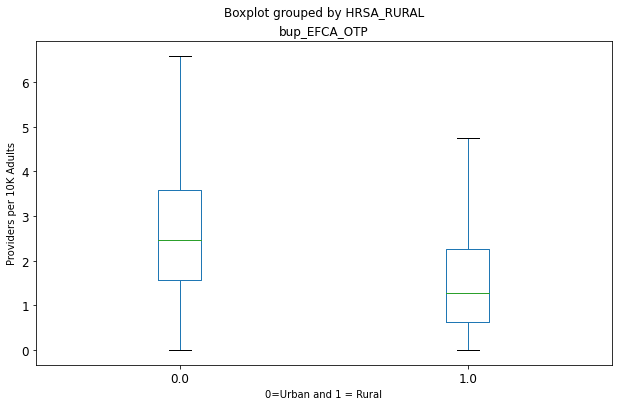

In [16]:
final_FCA = final_FCA[(final_FCA.total18to64!=0)|(final_FCA.GEOID_Data[12:14]!='99')]

plot = final_FCA.boxplot('bup_EFCA_OTP', by='HRSA_RURAL', showfliers=False, grid=False, figsize=(10,6), fontsize=12)

plot.set(xlabel="0=Urban and 1 = Rural", ylabel="Providers per 10K Adults")

plt.show(plot) 

Analysis statistically comparing accessibility to buprenorphine providers by rural status of census tracts in US

In [17]:
mod = ols('bup_EFCA_OTP ~ HRSA_RURAL', data=final_FCA).fit()
anova_table = sm.stats.anova_lm(mod, typ=2)
print(anova_table)

                   sum_sq       df            F  PR(>F)
HRSA_RURAL   10428.535223      1.0  2236.789972     0.0
Residual    341702.969258  73291.0          NaN     NaN


Tukey post-hoc analysis to see where differences occured (if above test is statistically significant)

In [18]:
m_comp = pairwise_tukey(data=final_FCA, dv='bup_EFCA_OTP', between='HRSA_RURAL')
print(m_comp)

     A    B   mean(A)   mean(B)      diff        se          T  p-tukey  \
0  0.0  1.0  2.805684  1.861756  0.943928  0.019958  47.294714    0.001   

     hedges  
0  0.437155  


Look at homogeneity of variance assumption - Buprenorphine Providers

In [19]:
scipy.stats.levene(final_FCA['bup_EFCA_OTP'][final_FCA['HRSA_RURAL']==1],
                   final_FCA['bup_EFCA_OTP'][final_FCA['HRSA_RURAL']==0])

LeveneResult(statistic=1.5648214830422653, pvalue=0.21096464971079476)

Look at normality assumption - Buprenorphine Providers

In [20]:
normal = scipy.stats.shapiro(mod.resid)
print('Normality Statistic is: ',str(normal[0]))
print('P-Value for Normality is: ',str(normal[1]))

Normality Statistic is:  0.6168217062950134
P-Value for Normality is:  0.0


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Perform analysis using nonparametric test due to violation of assumptions - Buprenorphine Providers

In [21]:
scipy.stats.ranksums(final_FCA['bup_EFCA_OTP'][final_FCA['HRSA_RURAL']==1],
                     final_FCA['bup_EFCA_OTP'][final_FCA['HRSA_RURAL']==0])

RanksumsResult(statistic=-83.2859513576778, pvalue=0.0)

Look at distribution of OTP access by rurality

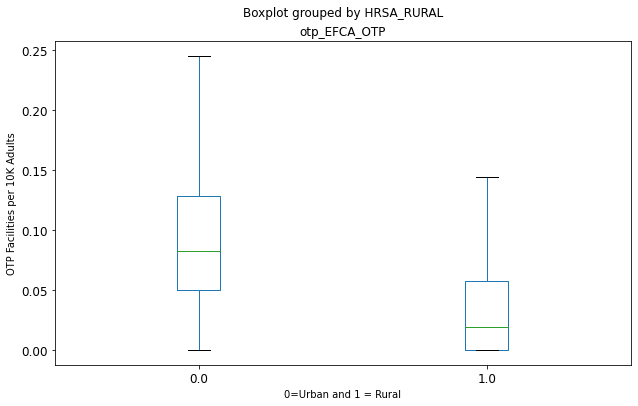

In [22]:
plot = final_FCA.boxplot('otp_EFCA_OTP', by='HRSA_RURAL', showfliers=False, grid=False, figsize=(10,6), fontsize=12)

plot.set(xlabel="0=Urban and 1 = Rural", ylabel="OTP Facilities per 10K Adults")

plt.show(plot) 

Analysis statistically comparing accessibility to opioid treatment facilities by rural status of census tracts in US

In [23]:
mod = ols ('otp_EFCA_OTP ~ HRSA_RURAL', data=final_FCA).fit()
anova_table = sm.stats.anova_lm(mod, typ=2)
print(anova_table)

                sum_sq       df            F  PR(>F)
HRSA_RURAL   28.873999      1.0  4690.099925     0.0
Residual    451.206654  73291.0          NaN     NaN


Tukey post-hoc analysis to see where differences occured (if above test is statistically significant)

In [24]:
m_comp = pairwise_tukey(data=final_FCA, dv='otp_EFCA_OTP', between='HRSA_RURAL')
print(m_comp)

     A    B   mean(A)   mean(B)      diff        se          T  p-tukey  \
0  0.0  1.0  0.099231  0.049562  0.049668  0.000725  68.484304    0.001   

     hedges  
0  0.633015  


Look at homogeneity of variance assumption - OTP

In [25]:
scipy.stats.levene(final_FCA['otp_EFCA_OTP'][final_FCA['HRSA_RURAL']==1],
                   final_FCA['otp_EFCA_OTP'][final_FCA['HRSA_RURAL']==0])

LeveneResult(statistic=58.536734876255835, pvalue=2.0195500218866736e-14)

Look at normality assumption - OTP

In [26]:
normal = scipy.stats.shapiro(mod.resid)
print('Normality Statistic is: ',str(normal[0]))
print('P-Value for Normality is: ',str(normal[1]))

Normality Statistic is:  0.7556513547897339
P-Value for Normality is:  0.0


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Perform analysis using nonparametric test due to violation of assumptions - OTP

In [27]:
scipy.stats.ranksums(final_FCA['otp_EFCA_OTP'][final_FCA['HRSA_RURAL']==1],
                     final_FCA['otp_EFCA_OTP'][final_FCA['HRSA_RURAL']==0])

RanksumsResult(statistic=-109.42327077111396, pvalue=0.0)